# EXPLORING THE DIFFERENCES BETWEEN KNOWN FUNCTIONAL AND UNKNOWN LIGAND BINDING SITES

## IMPORTING NECESSARY PACKAGES

In [2]:
from fragsys_analysis import *

## READING INPUT DATA

In [3]:
main_dir = "."
results_dir = os.path.join(main_dir, "results/new")
figs_dir = os.path.join(main_dir, "figs")

In [4]:
all_bs_ress = pd.read_pickle(os.path.join(results_dir, "all_bs_ress.pkl"))
all_bss = pd.read_pickle(os.path.join(results_dir, "all_bss.pkl"))
all_bs_ress["RSA"] = all_bs_ress["RSA"].apply(lambda x: x if x <= 100 else 100)
func_df = load_pickle(os.path.join(results_dir, "prot_func_dict_comb.pkl"))

In [5]:
func_df.head(3)

,bs_id,auto,manual,comb
0,H0Y4R8_0_BS0,UF,UF,UF
1,O15178_0_BS0,UF,UF,UF
2,O15178_0_BS1,UF,UF,UF


In [6]:
func_df.comb.value_counts()

UF    249
KF     44
Name: comb, dtype: int64

In [7]:
func_dict = {}
for _, row in func_df.iterrows():
    prot, group, bs = row.bs_id.split("_")
    func_dict[(prot, group, bs)] = row.comb # combination of automated feature extraction and manual one

In [8]:
func = []
unk = []
for k, v in func_dict.items():
    prot = k[0]
    group = k[1]
    bs_id = k[2]
    sel_rows = all_bs_ress[(all_bs_ress.protein == prot)&(all_bs_ress.group == group)&(all_bs_ress[bs_id] == 1)]
    if v == "KF":
        func.append(sel_rows)
    elif v == "UF":
        unk.append(sel_rows)
func_df = pd.concat(func)
unk_df = pd.concat(unk)

In [9]:
print(len(func_df))
print(len(unk_df))

5767
8456


In [14]:
func_df = func_df.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"]).reset_index(drop = True)
unk_df = unk_df.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"]).reset_index(drop = True)

In [15]:
print(len(func_df))
print(len(unk_df))

691
2050


### RSA, MES, AND SHENKIN DO NOT FOLLOW A NORMAL DISTRIBUTION

In [16]:
print(scipy.stats.normaltest(func_df.log_oddsratio.tolist()))
print(scipy.stats.normaltest(unk_df.log_oddsratio.tolist()))

NormaltestResult(statistic=27.07434797148578, pvalue=1.320930710983096e-06)
NormaltestResult(statistic=64.17466730550994, pvalue=1.1605077781952838e-14)


In [17]:
print(scipy.stats.normaltest(func_df.shenkin.tolist()))
print(scipy.stats.normaltest(unk_df.shenkin.tolist()))

NormaltestResult(statistic=78.14182283023712, pvalue=1.0757683664834876e-17)
NormaltestResult(statistic=215.75923969317964, pvalue=1.4075907065839778e-47)


In [18]:
print(scipy.stats.normaltest(func_df.RSA.tolist()))
print(scipy.stats.normaltest(unk_df.RSA.tolist()))

NormaltestResult(statistic=99.0439945451912, pvalue=3.1107839652197576e-22)
NormaltestResult(statistic=161.07691023320206, pvalue=1.0534001160040116e-35)


## FUNCTIONAL VS UNKNOWN: RSA

691 2050


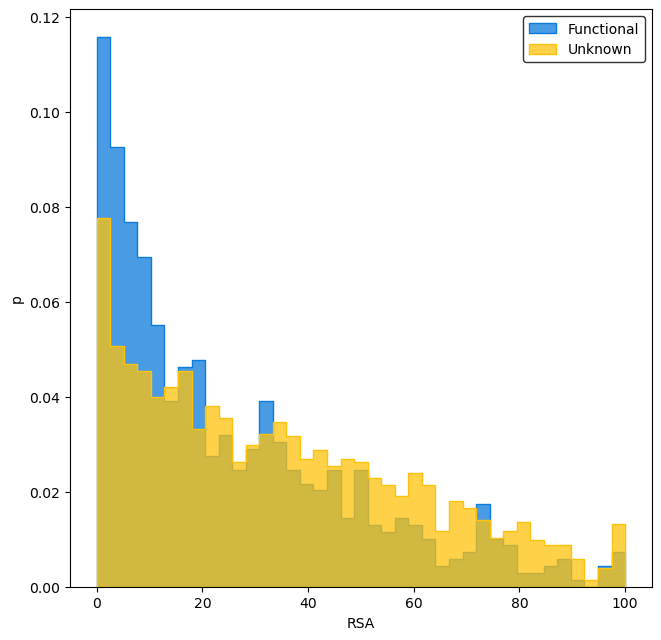

In [22]:
fig = plt.figure(figsize = (7.5, 7.5), dpi = 100)
RSA_bns = np.linspace(0, 100, 40)
a = func_df.query('RSA == RSA').RSA
b = unk_df.query('RSA == RSA').RSA
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = RSA_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = RSA_bns)
plt.ylabel("p")
plt.xlabel("RSA")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(figs_dir, "FUNC_vs_UNK_rsa.png"))
plt.show()

In [23]:
scipy.stats.anderson_ksamp([a, b])

/tmp/1188589.1.all.q/ipykernel_80446/3228072165.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp([a, b])


Anderson_ksampResult(statistic=42.72297518369387, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [24]:
print("RSA average (ALL residues) = ", round(statistics.mean(a),1))
print("RSA average (BS residues) = ", round(statistics.mean(b),1))

s, p = scipy.stats.ks_2samp(a, b, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(a, b, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(a, b)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

RSA average (ALL residues) =  25.4
RSA average (BS residues) =  34.1
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.17	p = 0.0

Mann-Whitney U rank test result:
U = 561780.5	p = 0.0

T-test result:
T = -7.85	p = 0.0


## FUNCTIONAL VS UNKNOWN: DIVERGENCE

468 1197


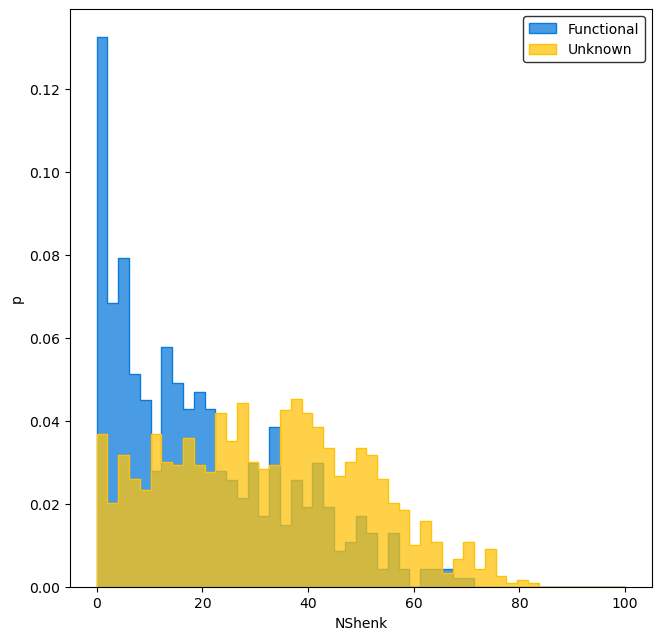

In [26]:
fig = plt.figure(figsize = (7.5, 7.5), dpi = 100)
shenk_bns = np.linspace(0, 100, 50)
a = func_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin
b = unk_df.query('occ >= 25 and occ_pct >= 0.50').abs_norm_shenkin
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = shenk_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = shenk_bns)
plt.ylabel("p")
plt.xlabel("NShenk")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(figs_dir, "FUNC_vs_UNK_shenk.png"))
plt.show()

In [27]:
scipy.stats.anderson_ksamp([a, b])

/tmp/1188589.1.all.q/ipykernel_80446/3228072165.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp([a, b])


Anderson_ksampResult(statistic=104.75819493187241, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [28]:
print("Shenkin average (FUNCTIONAL residues) = ", round(statistics.mean(a),0))
print("Shenkin average (UNKNOWN residues) = ", round(statistics.mean(b),0))

s, p = scipy.stats.ks_2samp(a, b, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(a, b, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(a,b)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

Shenkin average (FUNCTIONAL residues) =  20.0
Shenkin average (UNKNOWN residues) =  32.0
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.32	p = 0.0

Mann-Whitney U rank test result:
U = 169182.0	p = 0.0

T-test result:
T = -12.91	p = 0.0


## FUNCTIONAL VS UNKNOWN: MES

372 857


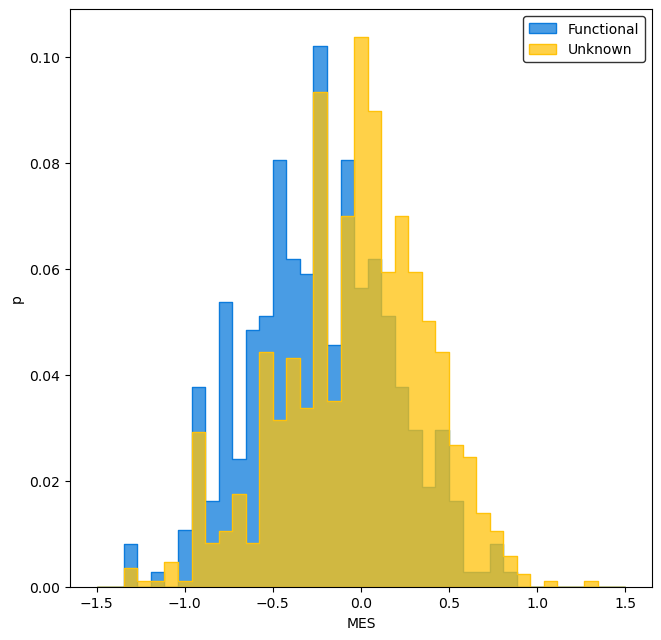

In [32]:
fig = plt.figure(figsize = (7.5, 7.5), dpi = 100)
mes_bns = np.linspace(-1.5, 1.5, 40)
a = func_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio
b = unk_df.query('occ >= 25 and occ_pct >= 0.50 & human_occ > 10 & human_occ_pct > 0.50 & variants >= 2').log_oddsratio
print(len(a), len(b))
sns.histplot(a, label = "Functional", fill = True, color = "#0C7BDC", stat = "proportion", element = "step", bins = mes_bns)
sns.histplot(b, label = "Unknown", fill = True, color = "#FFC20A", stat = "proportion", element = "step", bins = mes_bns)
plt.ylabel("p")
plt.xlabel("MES")
plt.legend(edgecolor = "k")
#plt.savefig(os.path.join(figs_dir, "FUNC_vs_UNK_MES.png"))
plt.show()

In [33]:
scipy.stats.anderson_ksamp([a, b])

/tmp/1188589.1.all.q/ipykernel_80446/3228072165.py:1: UserWarning: p-value floored: true value smaller than 0.001
  scipy.stats.anderson_ksamp([a, b])


Anderson_ksampResult(statistic=45.72428785837081, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)

In [34]:
print("MES average (FUNCIONAL residues) = ", round(statistics.mean(a),1))
print("MES average (UNKNOWN residues) = ", round(statistics.mean(b),1))

s, p = scipy.stats.ks_2samp(a, b, alternative="two-sided")
print("Kolmogorov-Smirnov two sample test result:\nKS statistic = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.mannwhitneyu(a, b, alternative="two-sided")
print("Mann-Whitney U rank test result:\nU = {}\tp = {}\n".format(round(s,2), round(p,2)))

s, p = scipy.stats.ttest_ind(a, b)
print("T-test result:\nT = {}\tp = {}".format(round(s,2), round(p,2)))

MES average (FUNCIONAL residues) =  -0.2
MES average (UNKNOWN residues) =  -0.0
Kolmogorov-Smirnov two sample test result:
KS statistic = 0.26	p = 0.0

Mann-Whitney U rank test result:
U = 111507.0	p = 0.0

T-test result:
T = -8.35	p = 0.0
